<a href="https://colab.research.google.com/github/Lyu-Sterkh/Sentiment-analysis/blob/main/Vader%26RoBERTa_on_clean_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 39.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 58.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 20.2 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from transformers import pipeline
from scipy.special import softmax
import re
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

In [ ]:
nltk.download('wordnet')
nltk.download('words')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('stopwords')
nltk.download('vader_lexicon')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping chunkers/maxent_ne_chunker.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [ ]:
# Google Drive mounting
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Read in data

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/DS/ВКР/NLP/Datasets/df_sent.csv', index_col='Unnamed: 0')
df.head()

,Id,Score,Text
0,1,5,I have bought several of the Vitality canned d...
1,2,1,Product arrived labeled as Jumbo Salted Peanut...
2,3,4,This is a confection that has been around a fe...
3,4,2,If you are looking for the secret ingredient i...
4,5,5,Great taffy at a great price. There was a wid...


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4984 entries, 0 to 4999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Id      4984 non-null   int64 
 1   Score   4984 non-null   int64 
 2   Text    4984 non-null   object
dtypes: int64(2), object(1)
memory usage: 155.8+ KB


# Preprocessing

In [ ]:
stop_words = ['br', 'href']

In [ ]:
def df_preprocess(text):
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))', 'site', text)
    text = re.sub('@[^\s]+', 'user', text)
    text = re.sub('[!"\\#\\$%\\&\'\\(\\)\\*\\+,\\-\\./:;<=>\\?@\\[\\\\\\]\\^_`\\{\\|\\}\\~]', ' ', text)
    text = re.sub('[^A-Za-z]', ' ', text)
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

In [ ]:
df['Text'] = df['Text'].apply(df_preprocess)

In [ ]:
df.head()

,Id,Score,Text
0,1,5,I have bought several of the Vitality canned d...
1,2,1,Product arrived labeled as Jumbo Salted Peanut...
2,3,4,This is a confection that has been around a fe...
3,4,2,If you are looking for the secret ingredient i...
4,5,5,Great taffy at a great price There was a wide ...


In [ ]:
df['Text'][25]

'Product received is as advertised a site Strawberry Ounce Bags Pack of a'

In [ ]:
df['Text'][30]

'I have never been a huge coffee fan However my mother purchased this little machine and talked me into trying the Latte Macciato No Coffee Shop has a better one and I like most of the other products too as a usually non coffee drinker The little Dolche Guesto Machine is super easy to use and prepares a really good Coffee Latte Cappuccino etc in less than a minute if water is heated up I would recommend the Dolce Gusto to anyone Too good for the price and I am getting one myself'

# Tweets classification

## VADER 

( Valence Aware Dictionary for Sentiment Reasoning) is an NLTK module that provides sentiment scores based on the words used.

In [ ]:
sia = SentimentIntensityAnalyzer()

In [ ]:
sia.polarity_scores('Live long and prosper!')

{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}

In [ ]:
sia.polarity_scores('burn in hell!')

{'neg': 0.71, 'neu': 0.29, 'pos': 0.0, 'compound': -0.7088}

In [ ]:
example1 = df['Text'].iloc[30]
example1

'This offer is a great price and a great taste thanks Amazon for selling this product Staral'

In [ ]:
sia.polarity_scores(example1)

{'neg': 0.0, 'neu': 0.462, 'pos': 0.538, 'compound': 0.9153}

In [ ]:
example2 = df['Text'].iloc[60]
example2

'This bag of candy online is pretty expensive it should be cheaper in order to compete with grocery stores other than that its a good combination of my favorite candy'

In [ ]:
sia.polarity_scores(example2)

{'neg': 0.0, 'neu': 0.741, 'pos': 0.259, 'compound': 0.8442}

In [ ]:
# Run the polarity score on the entire dataset
res_vader = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row['Text']
    df_id = row['Id']
    res_vader[df_id] = sia.polarity_scores(text)

  0%|          | 0/4984 [00:00<?, ?it/s]

In [ ]:
vaders = pd.DataFrame(res_vader)

In [ ]:
vaders.head()

,1,2,3,4,5,6,7,8,9,10,...,4991,4992,4993,4994,4995,4996,4997,4998,4999,5000
neg,0.0000,0.1340,0.0920,0.0000,0.0000,0.0580,0.0340,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.1120,0.000,0.0750,0.0260,0.0260,0.0360,0.1010,0.0520
neu,0.6950,0.8660,0.7510,0.9250,0.5520,0.7880,0.7050,0.5290,0.8460,0.7050,...,0.5650,0.8260,0.8500,0.690,0.7200,0.8790,0.7610,0.8030,0.5610,0.7080
pos,0.3050,0.0000,0.1570,0.0750,0.4480,0.1550,0.2620,0.4710,0.1540,0.2950,...,0.4350,0.1740,0.0380,0.310,0.2060,0.0950,0.2130,0.1610,0.3370,0.2400
compound,0.9441,-0.5664,0.8265,0.4404,0.9468,0.8253,0.9273,0.9436,0.6369,0.8313,...,0.9531,0.6908,-0.7964,0.967,0.7739,0.7193,0.9846,0.9153,0.9921,0.9812


In [ ]:
vaders = vaders.T
vaders = vaders.reset_index().rename(columns={'index': 'Id'})
vaders = vaders.merge(df, how='left')

In [ ]:
vaders.head()

,Id,neg,neu,pos,compound,Score,Text
0,1,0.000,0.695,0.305,0.9441,5,I have bought several of the Vitality canned d...
1,2,0.134,0.866,0.000,-0.5664,1,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.092,0.751,0.157,0.8265,4,This is a confection that has been around a fe...
3,4,0.000,0.925,0.075,0.4404,2,If you are looking for the secret ingredient i...
4,5,0.000,0.552,0.448,0.9468,5,Great taffy at a great price There was a wide ...


In [ ]:
df['Text'].iloc[0]

'I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.'

### VADER results visualisation

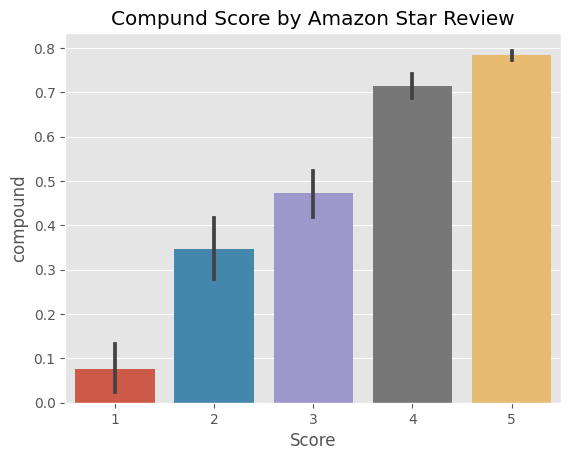

In [ ]:
ax = sns.barplot(data=vaders, x='Score', y='compound')
ax.set_title('Compund Score by Amazon Star Review')
#plt.savefig('/content/drive/MyDrive/DS/ВКР/NLP/Compund Score by Amazon Star Review.jpeg')
plt.show()

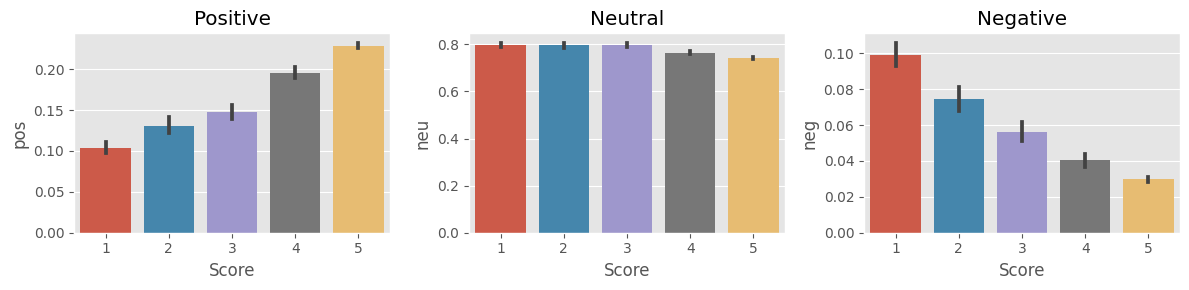

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=vaders, x='Score', y='pos', ax=axs[0])
sns.barplot(data=vaders, x='Score', y='neu', ax=axs[1])
sns.barplot(data=vaders, x='Score', y='neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
#plt.savefig('/content/drive/MyDrive/DS/ВКР/NLP/Scores by Amazon Star Review.jpeg')
plt.show()

## RoBERTa Pretrained Model

In [ ]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [ ]:
example = df['Text'].iloc[0]
example

'I have bought several of the Vitality canned dog food products and have found them all to be of good quality The product looks more like a stew than a processed meat and it smells better My Labrador is finicky and she appreciates this product better than most'

In [ ]:
# Run for Roberta Model on example
encoded_text = tokenizer(example, return_tensors='pt')
encoded_text

{'input_ids': tensor([[    0,   100,    33,  2162,   484,     9,     5, 23911,  1571, 24623,
          2335,   689,   785,     8,    33,   303,   106,    70,     7,    28,
             9,   205,  1318,    20,  1152,  1326,    55,   101,    10, 24571,
            87,    10, 12069,  4884,     8,    24, 28078,   357,  1308, 26882,
            16,  8746, 14963,     8,    79, 14137,  1626,    42,  1152,   357,
            87,   144,     2]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1]])}

In [ ]:
output = model(**encoded_text)
output

SequenceClassifierOutput(loss=None, logits=tensor([[-2.1071, -0.3226,  3.0196]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

In [ ]:
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores

array([0.00570065, 0.03395429, 0.96034503], dtype=float32)

In [ ]:
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
print(scores_dict)

{'roberta_neg': 0.0057006534, 'roberta_neu': 0.03395429, 'roberta_pos': 0.96034503}


In [ ]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict

In [ ]:
res_roberta = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['Text']
        df_id = row['Id']
        vader_result = sia.polarity_scores(text) 
        vader_result_rename = {}
        for key, value in vader_result.items():
            vader_result_rename[f"vader_{key}"] = value
        roberta_result = polarity_scores_roberta(text)
        both = {**vader_result_rename, **roberta_result}
        res_roberta[df_id] = both
    except RuntimeError:
        print(f'Broke for id {df_id}')

  0%|          | 0/4984 [00:00<?, ?it/s]

Broke for id 529
Broke for id 540
Broke for id 1053
Broke for id 1321
Broke for id 1498
Broke for id 1826
Broke for id 2248
Broke for id 2492
Broke for id 2584
Broke for id 2610
Broke for id 2898
Broke for id 2928
Broke for id 2942
Broke for id 3022
Broke for id 3023
Broke for id 3025
Broke for id 3306
Broke for id 4307
Broke for id 4316
Broke for id 4408
Broke for id 4583


In [ ]:
results_df = pd.DataFrame(res_roberta)
results_df.head()

,1,2,3,4,5,6,7,8,9,10,...,4991,4992,4993,4994,4995,4996,4997,4998,4999,5000
vader_neg,0.000000,0.1340,0.092000,0.000000,0.000000,0.058000,0.034000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.112000,0.000000,0.075000,0.026000,0.026000,0.036000,0.101000,0.052000
vader_neu,0.695000,0.8660,0.751000,0.925000,0.552000,0.788000,0.705000,0.529000,0.846000,0.705000,...,0.565000,0.826000,0.850000,0.690000,0.720000,0.879000,0.761000,0.803000,0.561000,0.708000
vader_pos,0.305000,0.0000,0.157000,0.075000,0.448000,0.155000,0.262000,0.471000,0.154000,0.295000,...,0.435000,0.174000,0.038000,0.310000,0.206000,0.095000,0.213000,0.161000,0.337000,0.240000
vader_compound,0.944100,-0.5664,0.826500,0.440400,0.946800,0.825300,0.927300,0.943600,0.636900,0.831300,...,0.953100,0.690800,-0.796400,0.967000,0.773900,0.719300,0.984600,0.915300,0.992100,0.981200
roberta_neg,0.005701,0.4319,0.001996,0.001424,0.001582,0.013009,0.001546,0.001973,0.002992,0.003075,...,0.001817,0.009274,0.904775,0.001399,0.224117,0.095582,0.011162,0.448822,0.017053,0.008649


In [ ]:
results_df = results_df.T
results_df = results_df.reset_index().rename(columns={'index': 'Id'})
results_df = results_df.merge(df, how='left')

In [ ]:
results_df.head()

,Id,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos,Score,Text
0,1,0.000,0.695,0.305,0.9441,0.005701,0.033954,0.960345,5,I have bought several of the Vitality canned d...
1,2,0.134,0.866,0.000,-0.5664,0.431900,0.533625,0.034475,1,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.092,0.751,0.157,0.8265,0.001996,0.090966,0.907038,4,This is a confection that has been around a fe...
3,4,0.000,0.925,0.075,0.4404,0.001424,0.056964,0.941612,2,If you are looking for the secret ingredient i...
4,5,0.000,0.552,0.448,0.9468,0.001582,0.010286,0.988132,5,Great taffy at a great price There was a wide ...


## Compare Scores between models

In [ ]:
results_df.columns.to_list()

['Id',
 'vader_neg',
 'vader_neu',
 'vader_pos',
 'vader_compound',
 'roberta_neg',
 'roberta_neu',
 'roberta_pos',
 'Score',
 'Text']

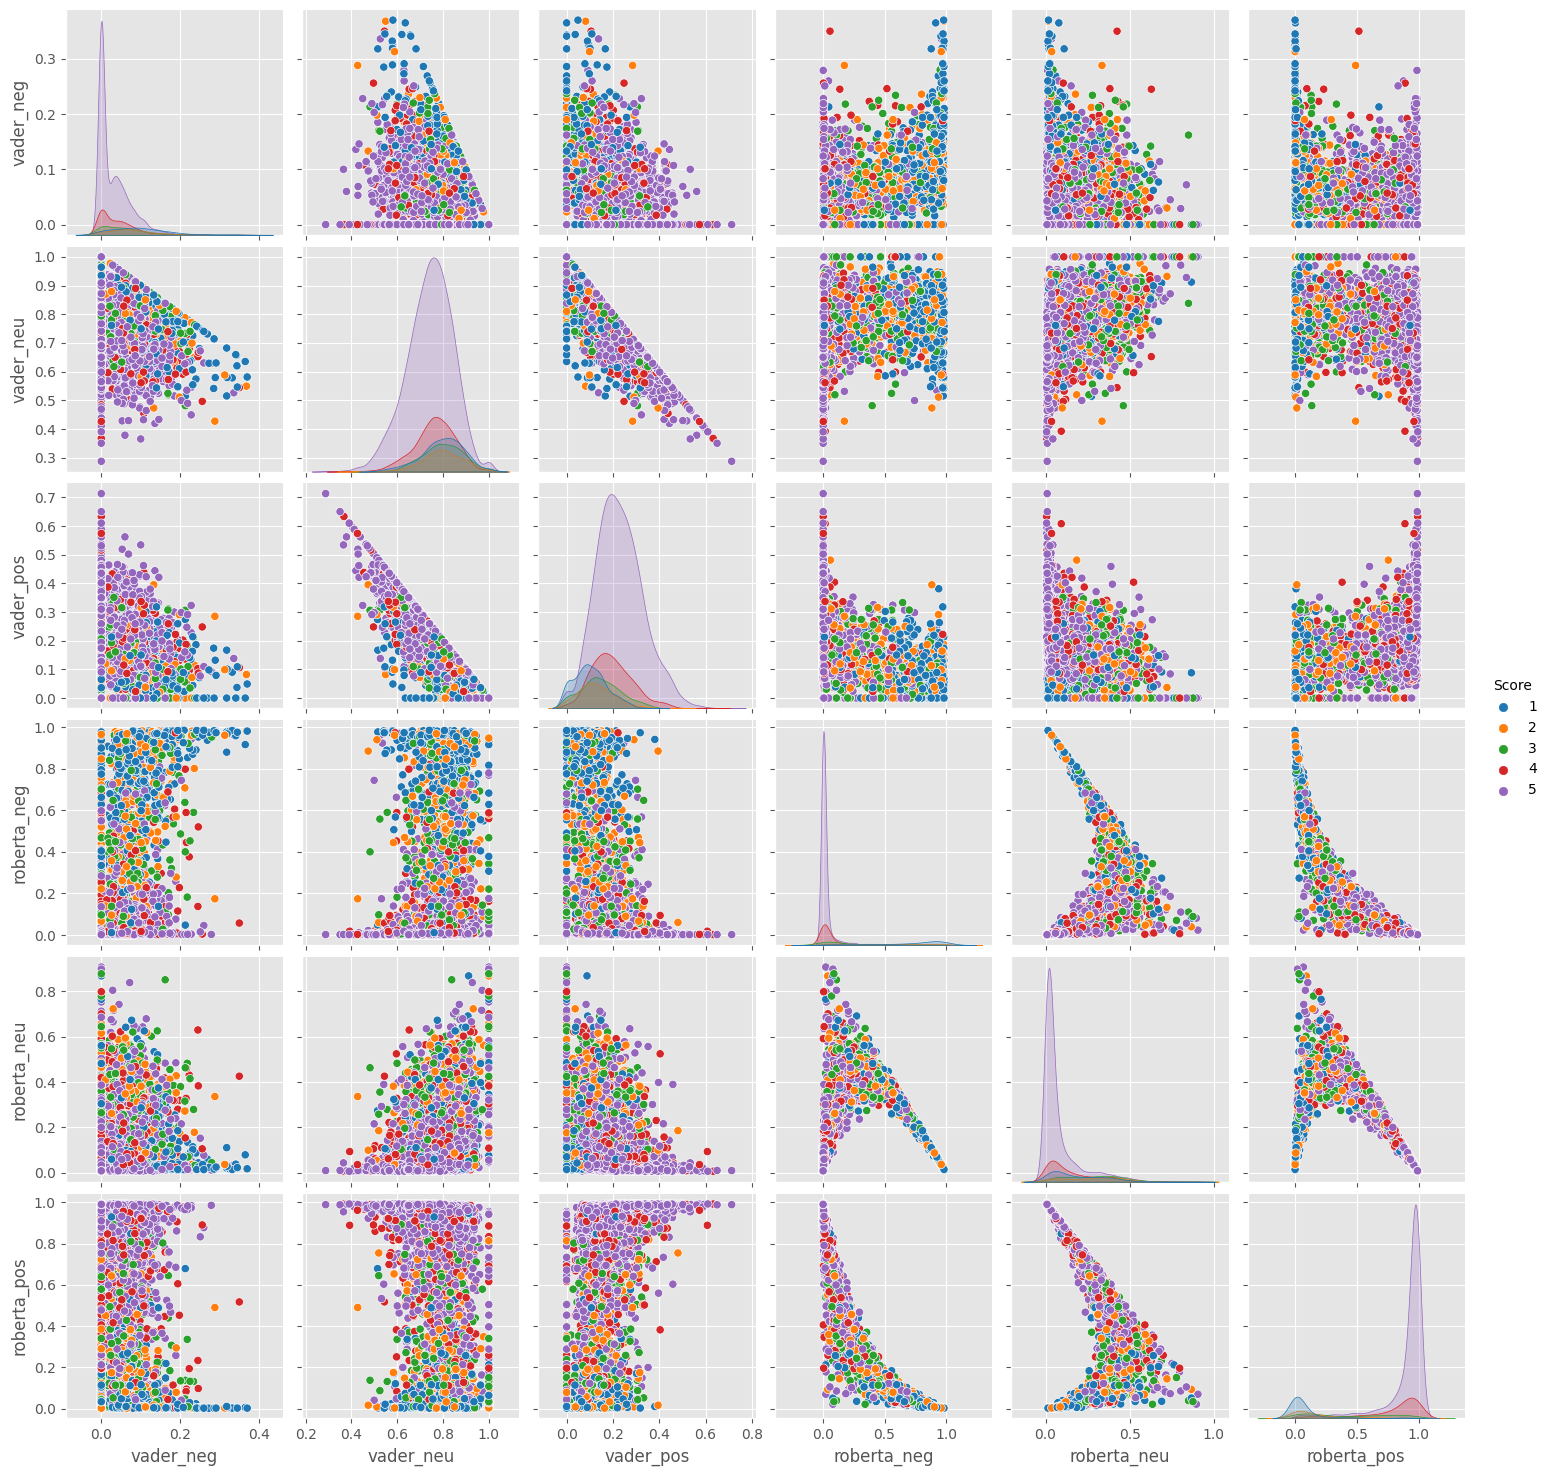

In [ ]:
sns.pairplot(data=results_df,
             vars=['vader_neg', 'vader_neu', 'vader_pos',
                  'roberta_neg', 'roberta_neu', 'roberta_pos'],
            hue='Score',
            palette='tab10')
#plt.savefig('/content/drive/MyDrive/DS/ВКР/NLP/Vader_Roberta_comparison2.jpeg')
plt.show()

## Loss examples


In [40]:
results_df.query('Score == 1') \
    .sort_values('roberta_pos', ascending=False)['Text'].values[0]

'Bisquick GF is easy to use Pancakes and muffins are very tasty The product is quick and easy to use It makes my day Gram'

In [43]:
results_df.query('Score == 1') \
    .sort_values('vader_pos', ascending=False)['Text'].values[25]

'These had heat and had good enough coating of the seasoning The first cases were amazing best i had ever Then they restocked and tried cases and they taste either like plain chips or slight hint of seasoning on them What a shame they seemed to cut back on quality to save money Bad Uncle Ray'